In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge, Lasso, LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from secondary_functions.get_metrics import concat_metrics, check_overfitting

from tqdm import tqdm_notebook
import yaml
import warnings
warnings.filterwarnings('ignore')

SEED = 1618

In [2]:
with open('preprocessing.yml', 'r', encoding='utf-8') as file:
    preproc_conf = yaml.load(file, Loader=yaml.FullLoader)
data_types = preproc_conf['change_type_columns']
data_types

{'Рейтинг': 'float32',
 'Мощность_двигателя_лс': 'int16',
 'Пробег_км': 'int32',
 'Год_выпуска': 'int16',
 'Цена': 'int32',
 'Объём_двигателя_л': 'float32',
 'Обмен': 'int8',
 'Много_владельцев': 'int8',
 'Срок_эксплуатации': 'int8',
 'История_пробега_кол_во_записей': 'int8',
 'Владельцев_по_ПТС': 'int8',
 'Выпуск_кол_во_лет': 'int8'}

# Загрузка данных, оптимизация, масштабирование и разбиение на train/test. 

In [3]:
df_train = pd.read_csv('./data_store/train.csv')
df_test = pd.read_csv('./data_store/test.csv')
df_train[:5]

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Поколение,...,Управление_климатом,ПТС,Обмен,Бренд_авто,Модель_авто,Город,Федеральный_округ,Много_владельцев,Срок_эксплуатации,Степень_износа
0,4.6,700000,2013.0,20800.0,19.0,4.0,2.0,5.0,135.0,I,...,Климат-контроль многозонный,Оригинал,0,Renault,Duster,Нижневартовск,Уральский,1,11,Маленькая
1,4.9,1300000,2014.0,400000.0,18.0,2.0,2.0,3.0,148.0,XV50,...,Управление на руле,Оригинал,0,Toyota,Camry,Москва,Центральный,0,10,Большая
2,4.7,749900,2008.0,165000.0,7.0,2.0,1.6,4.0,122.0,ED,...,Климат-контроль однозонный,Оригинал,0,Kia,Ceed,Екатеринбург,Уральский,0,16,Средняя
3,4.8,610000,2011.0,286000.0,20.0,3.0,1.4,4.0,160.0,Mk6,...,Управление на руле,Дубликат,1,Volkswagen,Golf,Дмитров,Центральный,0,13,Большая
4,4.8,5000000,2014.0,245000.0,32.0,4.0,4.5,3.0,235.0,200 рестайлинг,...,Климат-контроль многозонный,Оригинал,0,Toyota,Land Cruiser,Екатеринбург,Уральский,1,10,Большая


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31547 entries, 0 to 31546
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Рейтинг                         31547 non-null  float64
 1   Цена                            31547 non-null  int64  
 2   Год_выпуска                     31547 non-null  float64
 3   Пробег_км                       31547 non-null  float64
 4   История_пробега_кол_во_записей  31547 non-null  float64
 5   Владельцев_по_ПТС               31547 non-null  float64
 6   Объём_двигателя_л               31547 non-null  float64
 7   Выпуск_кол_во_лет               31547 non-null  float64
 8   Мощность_двигателя_лс           31547 non-null  float64
 9   Поколение                       31547 non-null  object 
 10  Состояние                       31547 non-null  object 
 11  Модификация                     31547 non-null  object 
 12  Тип_двигателя                   

Подготовим наш Baseline, чтобы определиться с итоговым алгоритмом. Попробуем линейную регрессию и её регуляризованные варианты, а также бустинги. Но прежде, немного оптимизируем датасет относительно памяти.

In [5]:
df_train = df_train.astype(data_types)
df_train[df_train.select_dtypes('object').columns] = df_train[
    df_train.select_dtypes('object').columns].astype('category')
df_test = df_test.astype(data_types)
df_test[df_test.select_dtypes('object').columns] = df_test[
    df_test.select_dtypes('object').columns].astype('category')

In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31547 entries, 0 to 31546
Data columns (total 29 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Рейтинг                         31547 non-null  float32 
 1   Цена                            31547 non-null  int32   
 2   Год_выпуска                     31547 non-null  int16   
 3   Пробег_км                       31547 non-null  int32   
 4   История_пробега_кол_во_записей  31547 non-null  int8    
 5   Владельцев_по_ПТС               31547 non-null  int8    
 6   Объём_двигателя_л               31547 non-null  float32 
 7   Выпуск_кол_во_лет               31547 non-null  int8    
 8   Мощность_двигателя_лс           31547 non-null  int16   
 9   Поколение                       31547 non-null  category
 10  Состояние                       31547 non-null  category
 11  Модификация                     31547 non-null  category
 12  Тип_двигателя     

Отлично! Уменьшили расход памяти для датасета на 77%. Для регрессий подготовим масштабированные данные с one-hot-encoding, для бустингов будем подавать как есть.

In [7]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore', drop='first')
df_train_labeled = df_train.copy()
cat_columns = df_train_labeled.select_dtypes('category').columns.tolist()
num_columns = df_train_labeled.select_dtypes(
    exclude='category').columns.tolist()

encoded_features = encoder.fit_transform(df_train_labeled[cat_columns])
feature_names = encoder.get_feature_names_out(cat_columns)
encoded_df = pd.DataFrame(encoded_features,
                          columns=feature_names,
                          index=df_train_labeled.index)

df_train_labeled = pd.concat([df_train_labeled[num_columns], encoded_df],
                             axis=1)
df_train_labeled[:5]

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Обмен,...,Федеральный_округ_Приволжский,Федеральный_округ_Северо-Западный,Федеральный_округ_Северо-Кавказский,Федеральный_округ_Сибирский,Федеральный_округ_Уральский,Федеральный_округ_Центральный,Федеральный_округ_Южный,Степень_износа_Маленькая,Степень_износа_Средняя,Степень_износа_Умеренная
0,4.6,700000,2013,20800,19,4,2.0,5,135,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,4.9,1300000,2014,400000,18,2,2.0,3,148,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.7,749900,2008,165000,7,2,1.6,4,122,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,4.8,610000,2011,286000,20,3,1.4,4,160,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,4.8,5000000,2014,245000,32,4,4.5,3,235,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [8]:
df_test_labeled = df_test.copy()
encoded_features = encoder.transform(df_test_labeled[cat_columns])
feature_names = encoder.get_feature_names_out(cat_columns)
encoded_df = pd.DataFrame(encoded_features,
                          columns=feature_names,
                          index=df_test_labeled.index)

df_test_labeled = pd.concat([df_test_labeled[num_columns], encoded_df], axis=1)
df_test_labeled[:5]

,Рейтинг,Цена,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Обмен,...,Федеральный_округ_Приволжский,Федеральный_округ_Северо-Западный,Федеральный_округ_Северо-Кавказский,Федеральный_округ_Сибирский,Федеральный_округ_Уральский,Федеральный_округ_Центральный,Федеральный_округ_Южный,Степень_износа_Маленькая,Степень_износа_Средняя,Степень_износа_Умеренная
0,4.8,1000000,2009,203290,9,4,1.8,3,140,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.7,799999,2006,270000,9,4,2.0,7,136,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.9,2019000,2023,21374,2,1,1.5,4,143,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4.8,745000,2013,154235,12,2,1.5,5,105,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4.5,2998000,2015,155099,5,3,2.0,3,238,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
scaler_x = StandardScaler()
X_train_sc, y_train_sc = df_train_labeled.drop(
    'Цена', axis=1), np.log(df_train_labeled['Цена'] + 1),
X_test_sc, y_test_sc = df_test_labeled.drop(
    'Цена', axis=1), np.log(df_test_labeled['Цена'] + 1)

In [10]:
X_test_sc

,Рейтинг,Год_выпуска,Пробег_км,История_пробега_кол_во_записей,Владельцев_по_ПТС,Объём_двигателя_л,Выпуск_кол_во_лет,Мощность_двигателя_лс,Обмен,Много_владельцев,...,Федеральный_округ_Приволжский,Федеральный_округ_Северо-Западный,Федеральный_округ_Северо-Кавказский,Федеральный_округ_Сибирский,Федеральный_округ_Уральский,Федеральный_округ_Центральный,Федеральный_округ_Южный,Степень_износа_Маленькая,Степень_износа_Средняя,Степень_износа_Умеренная
0,4.8,2009,203290,9,4,1.8,3,140,0,1,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.7,2006,270000,9,4,2.0,7,136,0,1,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,4.9,2023,21374,2,1,1.5,4,143,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,4.8,2013,154235,12,2,1.5,5,105,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,4.5,2015,155099,5,3,2.0,3,238,1,0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5563,4.9,2020,78613,3,1,2.0,5,235,1,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5564,4.5,2011,260000,14,2,1.6,3,109,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5565,4.7,2014,108132,63,1,2.0,4,240,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5566,4.8,2011,200000,8,3,1.6,4,100,0,0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [11]:
X_train_sc = scaler_x.fit_transform(X_train_sc)
X_test_sc = scaler_x.transform(X_test_sc)
y_train_t = np.exp(y_train_sc) - 1
y_test_t = np.exp(y_test_sc) - 1

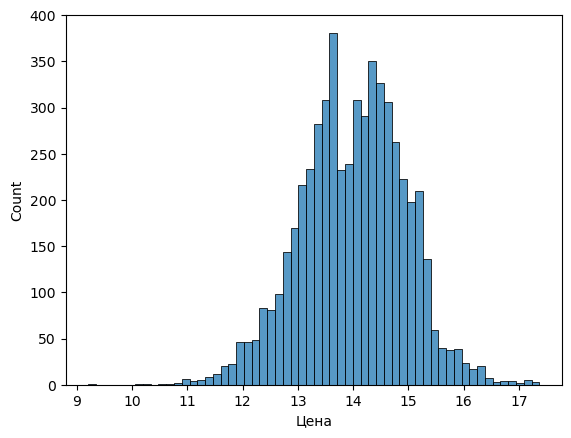

In [12]:
sns.histplot(y_test_sc);

In [13]:
X_test_sc.shape, y_test_sc.shape, X_train_sc.shape, y_train_sc.shape

((5568, 3999), (5568,), (31547, 3999), (31547,))

In [14]:
X_train, y_train = df_train.drop('Цена', axis=1),  df_train['Цена'] 
X_test, y_test = df_test.drop('Цена', axis=1), df_test['Цена']
cat_feature_names = list(X_train.select_dtypes('category').columns)

# Обучение baseline-моделей.

In [15]:
linear_baseline = LinearRegression()
lasso_baseline = Lasso(random_state=SEED)
ridge_baseline = Ridge(random_state=SEED)
elastic_baseline = ElasticNet(random_state=SEED)
forest_baseline = RandomForestRegressor(random_state=SEED)
xgb_baseline = XGBRegressor(enable_categorical=True, random_state=SEED)
lgbm_baseline = LGBMRegressor(verbosity=-1,
                              categorical_feature=cat_feature_names,
                              random_state=SEED)
catb_baseline = CatBoostRegressor(cat_features=cat_feature_names,
                                  verbose=0,
                                  random_state=SEED)

In [16]:
linear_models_list = [
    linear_baseline, lasso_baseline, ridge_baseline, elastic_baseline,
    forest_baseline
]

tree_models_list = [
    xgb_baseline, lgbm_baseline, catb_baseline
]

metrics = pd.DataFrame()

In [17]:
for model in tqdm_notebook(linear_models_list):
    model.fit(X_train_sc, y_train_sc)
    metrics = concat_metrics(
        metrics,
        y_train_t.values,
        np.exp(model.predict(X_train_sc)) - 1,
        X_train_sc,
        model_name=f'{model.__class__.__name__}_baseline_train')
    metrics = concat_metrics(
        metrics,
        y_test_t.values,
        np.exp(model.predict(X_test_sc)) - 1,
        X_test_sc,
        model_name=f'{model.__class__.__name__}_baseline_test')

  0%|          | 0/5 [00:00<?, ?it/s]

In [18]:
for model in tqdm_notebook(tree_models_list):
    model.fit(X_train, y_train)
    metrics = concat_metrics(
        metrics,
        y_train.values,
        model.predict(X_train),
        X_train,
        model_name=f'{model.__class__.__name__}_baseline_train')
    metrics = concat_metrics(
        metrics,
        y_test.values,
        model.predict(X_test),
        X_test,
        model_name=f'{model.__class__.__name__}_baseline_test')

  0%|          | 0/3 [00:00<?, ?it/s]

Мы разместили случайный лес вместе с линейными моделями, хотя он есть модель на основе деревьев. Сделано это потому, что обучался он на данных, подготовленных для линейных моделей с бинаризованными категориальными признаками.

# Сравнение метрик и выводы.

In [19]:
metrics

,Модель,MAE,R2_Adjusted,WAPE,RMSE
0,LinearRegression_baseline_train,249028.159471,0.91996,13.560751,635536.419119
0,LinearRegression_baseline_test,Input contains infinity or a value too large f...,Input contains infinity or a value too large f...,Input contains infinity or a value too large f...,Input contains infinity or a value too large f...
0,Lasso_baseline_train,1194565.806671,-0.230536,65.049712,2491925.831756
0,Lasso_baseline_test,1196316.914549,-2.861471,65.068591,2320008.049047
0,Ridge_baseline_train,200536.80212,0.960327,10.92017,447440.493691
0,Ridge_baseline_test,238029.494042,0.806056,12.946606,519937.883854
0,ElasticNet_baseline_train,1048375.622315,-0.107196,57.088971,2363743.505545
0,ElasticNet_baseline_test,1049296.021505,-2.437674,57.072013,2188998.185706
0,RandomForestRegressor_baseline_train,84011.382878,0.987391,4.574814,252249.525507
0,RandomForestRegressor_baseline_test,211355.270544,0.850325,11.495775,456759.583643


In [20]:
check_overfitting(X_train, y_train, X_test, y_test, catb_baseline)

CatBoostRegressor 
MAE train: 207165.83768589966 
MAE test: 230309.15243321127 
MAE diff: 10.05 %


In [21]:
check_overfitting(X_train, y_train, X_test, y_test, xgb_baseline)

XGBRegressor 
MAE train: 77833.54725625158 
MAE test: 711721.6532178856 
MAE diff: 89.06 %


In [22]:
check_overfitting(X_train, y_train, X_test, y_test, lgbm_baseline)

LGBMRegressor 
MAE train: 192106.04977678892 
MAE test: 225714.44521447778 
MAE diff: 14.89 %


Предсказания на тестовой выборке, которые мы получили от линейной и ридж регрессий содержат бесконечные значения. Это может быть связано с тем, что недостаточно регуляризации, или недостаточно данных чтобы она приблизила истинную зависимость. В бустингах наблюдаем отрицательный WAPE - это значит, что бустинги недооценивают автомобили, реальные цены выше чем предсказанные. XGBRegressor переобучился - это видно по разнице между ошибками на тестовой и тренировочной выборках. Из всех более приятны метрики у LGBM и CatBoost. В целом также неплохо показал себя и RandomForest, но он переобучился и r2 на тестовой выборке у него низковат. Попробуем обучить Catboost и LGBM - потенциально одна из них даст наилучший результат.
